### setup before running

1. download all 2019 data from "https://webrobots.io/kickstarter-datasets/"
2. make a folder called "raw_data"
3. within "raw_data" make 3 sub-folders with the date of the pulls in the format MM-DD-YYYY
3. extract downloaded data into each of the 3 sub-folders appropriately
4. in line 4 below change the "path_master" variable to your "raw_data" link
5. run (~7min)

### merge all csv

In [ ]:
import re
import os
import pandas as pd
path_master = r'C:/Users/endwy/Documents/Columbia MSBA/Spring 2019/E4650 - Business Analytics/Project - Kickstarter Analysis/raw_data/'
df_kickstarter = pd.DataFrame()

def add_date(path):
    return path[-10:-1]

directories = list()
for root, dirs, files in os.walk(path_master, topdown=False):
    for name in dirs:
        directories.append(os.path.join(root, name)+'/')

file_names = list()
for path, subdirs, files in os.walk(path_master):
    for filename in files:
        if filename not in file_names: file_names.append(filename)

for i in directories: 
    for j in file_names:
        try:
            with open(i+j, encoding='utf8') as fp:
                df_interim = pd.read_csv(fp, keep_default_na=False)
            df_interim['download_date'] = add_date(i)
            df_interim['download_date'] = pd.to_datetime(df_interim['download_date'], format='%m-%d-%Y')
            global df_kickstarter
            df_kickstarter = pd.concat([df_kickstarter,df_interim])
            print('SUCCESS: '+i+j)
        except:
            print('FAIL: '+i+j)
            pass
df_kickstarter.to_csv(path_master+'df_kickstarter'+'.csv')

### read in random sample % of full df_kickstarter to test with

In [ ]:
import pandas as pd
import os
import random
filename = r'C:/Users/endwy/Documents/Columbia MSBA/Spring 2019/E4650 - Business Analytics/Project - Kickstarter Analysis/raw_data/df_kickstarter.csv'

p = 1  # x% of the lines
# keep the header, then take only x% of lines
# if random from [0,1] interval is greater than p the row will be skipped
df = pd.read_csv(filename, header=0,  skiprows=lambda i: i>0 and random.random() > p)
len(df)
#df=df[:1000]
#len(df)

### categorize

In [ ]:
import json
cat_json = df['category'].apply(json.loads)
cat_name=list(map(lambda d: d['name'], cat_json))
df['Cat_Name']=cat_name
#df.sort_values(['Cat_Name'])

### funding date scraping 

In [ ]:
def get_url(x):
    return x.split("\"")[5]

df["urls"] = df["urls"].apply(lambda x: get_url(x))

In [ ]:
import requests
from bs4 import BeautifulSoup
from time import sleep
import datetime

processed = 0
def add_fundpd(x,y):
    user_agent_list = [
           #Chrome
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
            'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
            'Mozilla/5.0 (Windows NT 5.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
            'Mozilla/5.0 (Windows NT 6.2; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
            'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36',
            'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36',
            'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36',
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
            'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
            #Firefox
            'Mozilla/4.0 (compatible; MSIE 9.0; Windows NT 6.1)',
            'Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko',
            'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0)',
            'Mozilla/5.0 (Windows NT 6.1; Trident/7.0; rv:11.0) like Gecko',
            'Mozilla/5.0 (Windows NT 6.2; WOW64; Trident/7.0; rv:11.0) like Gecko',
            'Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7.0; rv:11.0) like Gecko',
            'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.0; Trident/5.0)',
            'Mozilla/5.0 (Windows NT 6.3; WOW64; Trident/7.0; rv:11.0) like Gecko',
            'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0)',
            'Mozilla/5.0 (Windows NT 6.1; Win64; x64; Trident/7.0; rv:11.0) like Gecko',
            'Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; WOW64; Trident/6.0)',
            'Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; Trident/6.0)',
            'Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 5.1; Trident/4.0; .NET CLR 2.0.50727; .NET CLR 3.0.4506.2152; .NET CLR 3.5.30729)'
        ]
    user_agent = random.choice(user_agent_list)
    heads = {'User-Agent': user_agent}
    #sleep(3)
    global proessed
    try:
        page = requests.get(x,headers=heads)
        results_page = BeautifulSoup(page.content,'lxml')
        period = results_page.find('div',class_='NS_campaigns__funding_period').find_all(class_="js-adjust-time")
        global processed
        processed+=1
        print("success: "+str(processed)+" : "+y+" : "+x[36:])
        start = pd.to_datetime(period[0].get_text(), format='%b %d, %Y').strftime('%Y-%m-%d')
        end = pd.to_datetime(period[1].get_text(), format='%b %d, %Y').strftime('%Y-%m-%d')
        delta = int(results_page.find('p',class_='f5').get_text().split("\n")[-2][1:-1].split()[0])
        if y=="start": result = start
        if y=="end": result = end
        if y=="delta": result = delta
        return result
    except:
        processed+=1
        print("FAIL: "+str(processed)+" : "+y+" : "+x[36:])
        result = "error"
        return result
df["funding_start"] = df["urls"].apply(lambda x: add_fundpd(x,'start'))
df["funding_end"] = df["urls"].apply(lambda x: add_fundpd(x,'end'))
df["funding_delta"] = df["urls"].apply(lambda x: add_fundpd(x,'delta'))

In [ ]:
df.head(3)

In [ ]:
import pandas as pd
import os
path_master = 'C:/Users/endwy/Documents/Columbia MSBA/Spring 2019/E4650 - Business Analytics/Project - Kickstarter Analysis/raw_data/'
filename = 'C:/Users/endwy/Documents/Columbia MSBA/Spring 2019/E4650 - Business Analytics/Project - Kickstarter Analysis/raw_data/df_kickstarterFE.csv'
df = pd.read_csv(filename, header=0)
#df.drop(columns=('Unnamed: 0'),inplace=True)
df.drop(columns=(['Unnamed: 0','converted_pledged_amount','usd_pledged']),inplace=True)
len(df.columns)

In [ ]:
path_master = 'C:/Users/endwy/Documents/Columbia MSBA/Spring 2019/E4650 - Business Analytics/Project - Kickstarter Analysis/raw_data/'
df.to_csv(path_master+'df_kickstarterFE.csv')

In [2]:
import numpy as np 
import pylab 
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('seaborn')
%matplotlib inline
   
stats.probplot(df[11], dist="norm", plot=pylab)
pylab.show()

### NLP / WordClouds

In [ ]:

def extract_creator_id(json_obj):
    try:
        temp=json.loads(json_obj)
    except:
        return None
    return temp['id']
    
creator_id = kickstarter_df['creator'].apply(extract_creator_id)

In [ ]:
def extract_reward_urls(json_obj):
    temp = json.loads(json_obj)
    return (temp['web']['rewards'])
    
reward_urls=kickstarter_df['urls'].apply(extract_reward_urls)

In [ ]:
def pull_reward_details(url_list):
    
    reward_tier = list()
    #Read the urls and extract details on rewarding tiers
    for i in url_list:
        #print(i)
        response=requests.get(i)
        if response.status_code!=200:
            print("Error pulling data from {}".format(i))
            continue
        reward_desc=bs(response.content,'lxml')
        try:
            a=reward_desc.find('ol').find_all('li')
            reward_tier.append(len(a))
        except:
            continue
    return (reward_tier)
        
reward_tier = pull_reward_details(reward_urls)

In [ ]:
a = pd.DataFrame({"Project_Id":kickstarter_df['id'],
                  "Creator_Id":creator_id,
                  "Reward_Tiers":reward_tier,
                  "Rewards_Url":reward_urls})
a

In [ ]:
reward_urls.head(10)

In [ ]:
#Adding the Word Cloud Segment, this needs to be applied on overfunded campaigns to better
#suggest what works best in this area

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from nltk import sent_tokenize,word_tokenize

#def generate wordclouds(df):
#df = pd.read_csv("df_testing.csv")  

MIN_LENGTH=5
DELETE_WORDS=['first','world','creat','music','project',]

def remove_words(text_string,DELETE_WORDS=DELETE_WORDS):
    for word in DELETE_WORDS:
        text_string = text_string.replace(word,' ')
    return text_string


def remove_short_words(text_string,min_length = MIN_LENGTH):
    word_list = text_string.split()
    for word in word_list:
        if len(word) < min_length:
            text_string = text_string.replace(' '+word+' ',' ',1)
    return text_string

In [ ]:
def aggregate_text(temp):
    p_stemmer = PorterStemmer()
    x=''
    for i in range(len(temp)):
        words = word_tokenize(temp['blurb'].iloc[i])
        text = ([p_stemmer.stem(i).lower() for i in words])
        text = ' '.join(text)
        x=x+' '+text
        
    return x.lower()

In [ ]:
category_list = list()
category_description=list()

COL_NUM = 2
ROW_NUM = 3
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(15,15))


def category_state_geography(df):
    count = 0
    df = df.dropna(how='any',axis=0)
    for i in df['state'].unique():
        temp = df[df['state']==i]
        temp_blurbs = aggregate_text(temp)
        temp_blurbs = remove_words(temp_blurbs)
        temp_blurbs = remove_short_words(temp_blurbs)
        category_list.append(i)
        category_description.append(temp_blurbs)
        ax = axes[count//2, count%2] 
        ax.set_title(i)
        wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=1200,height=1000,max_words=20).generate(temp_blurbs)
        ax.imshow(wordcloud)
        ax.axis('off')
        count+=1
    
category_state_geography(df[['blurb','state']])
plt.show()

In [ ]:
#df['state'].unique()
#df_new=df[df['state']=='successful']


<h2> Dominant Product Types per Region </h2>

In [28]:

geography_df = pd.read_csv('rewardtiering.csv')

In [29]:
geography_df.head(10)

,Unnamed: 0,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,...,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
0,1,108,"In the year 2025, a young man's superintellige...","{""id"":32,""name"":""Shorts"",""slug"":""film & video/...",5265,US,1474949898,"{""id"":917453276,""name"":""Ryan Turner"",""slug"":""r...",USD,$,...,a-date-in-2025-a-sci-fi-comedy-short-film,https://www.kickstarter.com/discover/categorie...,True,False,successful,1477674323,1,"{""web"":{""project"":""https://www.kickstarter.com...",5265.82,domestic
1,2,37,Replacement Place needs your support to combat...,"{""id"":254,""name"":""Performances"",""slug"":""dance/...",5225,US,1425755444,"{""id"":1584296239,""name"":""Patricia Noworol Danc...",USD,$,...,replacement-place-new-york-live-arts,https://www.kickstarter.com/discover/categorie...,True,True,successful,1431748742,1,"{""web"":{""project"":""https://www.kickstarter.com...",5225.00,domestic
2,3,27,Pumpkin Spice Love - A Pumpkin Spice 4 Life 30...,"{""id"":262,""name"":""Accessories"",""slug"":""fashion...",362,US,1504654576,"{""id"":1930804198,""name"":""Mandy Robertson"",""slu...",USD,$,...,pumpkin-spice-love,https://www.kickstarter.com/discover/categorie...,True,False,successful,1506112227,1,"{""web"":{""project"":""https://www.kickstarter.com...",362.00,domestic
3,4,184,Single mama and her 4-year old sail with all-f...,"{""id"":13,""name"":""Journalism"",""slug"":""journalis...",15678,US,1440164389,"{""id"":1435241906,""name"":""Ky Delaney"",""is_regis...",USD,$,...,pirate-mama-setting-sail-with-her-little-boy,https://www.kickstarter.com/discover/categorie...,True,False,successful,1446670947,1,"{""web"":{""project"":""https://www.kickstarter.com...",15678.00,international
4,7,1,Everyday for the next 40 days I will be creati...,"{""id"":21,""name"":""Digital Art"",""slug"":""art/digi...",12,US,1481895960,"{""id"":501028455,""name"":""Isaac Luna Silva"",""is_...",USD,$,...,abstract-digital-portraits,https://www.kickstarter.com/discover/categorie...,False,False,failed,1485365873,1,"{""web"":{""project"":""https://www.kickstarter.com...",12.00,domestic
5,9,26,The revolutionary hair scalp stimulator made f...,"{""id"":26,""name"":""Crafts"",""slug"":""crafts"",""posi...",8160,US,1459174156,"{""id"":1807028083,""name"":""Kaizan Corp."",""is_reg...",USD,$,...,keshin,https://www.kickstarter.com/discover/categorie...,True,False,successful,1472307907,1,"{""web"":{""project"":""https://www.kickstarter.com...",8160.00,domestic
6,10,2,I am a graphic design major. For my senior the...,"{""id"":21,""name"":""Digital Art"",""slug"":""art/digi...",100,US,1394114446,"{""id"":1935996164,""name"":""Ireland Wheeler"",""slu...",USD,$,...,the-anglophilia-project,https://www.kickstarter.com/discover/categorie...,False,False,failed,1396126813,1,"{""web"":{""project"":""https://www.kickstarter.com...",100.00,domestic
7,11,22,Production is complete! Now we need: post audi...,"{""id"":297,""name"":""Horror"",""slug"":""film & video...",3210,US,1496010979,"{""id"":1241002293,""name"":""Del Harvey"",""slug"":""r...",USD,$,...,dont-save-me-post-production-campaign,https://www.kickstarter.com/discover/categorie...,True,False,successful,1497744040,1,"{""web"":{""project"":""https://www.kickstarter.com...",3210.00,international
8,13,18,"Last Right's is a 24 episode webseries, that a...","{""id"":33,""name"":""Webseries"",""slug"":""film & vid...",12060,US,1307552648,"{""id"":706550490,""name"":""Jason Dallas"",""is_regi...",USD,$,...,last-rights,https://www.kickstarter.com/discover/categorie...,True,False,successful,1319811540,1,"{""web"":{""project"":""https://www.kickstarter.com...",12060.00,domestic
9,14,106,A dance theater duet about the science of cons...,"{""id"":6,""name"":""Dance"",""slug"":""dance"",""positio...",3735,US,1340753933,"{""id"":943024993,""name"":""Megan Mazarick and Mas...",USD,$,...,mining-the-mine-of-the

In [30]:
import json
def extract_category_columns(json_obj):
    temp = json.loads(json_obj)
    #print(temp)
    return (temp['name'])

geography_df['product_type']=geography_df['category'].apply(extract_category_columns)

In [34]:
def extract_location(json_obj):
    try:
        temp = json.loads(json_obj)
        try:
            a = int(temp['localized_name'])
            return None
        except:
            return temp['localized_name']
    except:
        return None
    
geography_df['local_name']=geography_df['location'].apply(extract_location)

In [35]:
geography_df = geography_df[['backers_count','converted_pledged_amount','slug','currency_symbol','product_type','local_name','spotlight','goal']]

In [36]:
geography_df.dropna(axis=0,how='any',inplace=True)

In [67]:
goals = geography_df[['local_name','goal']].groupby('local_name').sum()

In [68]:
goals.reset_index(level=0,inplace=True)

In [83]:
printtemp = goals.sort_values('goal',ascending = False)
printtemp.head(10)

,local_name,goal
2120,Las Vegas,1.123810e+08
1836,Indianapolis,1.055549e+08
109,Antarctica,1.001929e+08
163,Atlanta,9.234024e+07
2766,New York,9.186977e+07
2256,Los Angeles,9.024562e+07
3528,San Diego,8.661894e+07
4473,Winnemucca,8.000000e+07
1756,Hollywood,5.870330e+07
3131,Philadelphia,5.721191e+07


(array([2., 0., 0., 0., 1., 2., 2., 1., 1., 1.]),
 array([5.72119140e+07, 6.27288256e+07, 6.82457372e+07, 7.37626488e+07,
        7.92795604e+07, 8.47964720e+07, 9.03133836e+07, 9.58302952e+07,
        1.01347207e+08, 1.06864118e+08, 1.12381030e+08]),
 <a list of 10 Patch objects>)

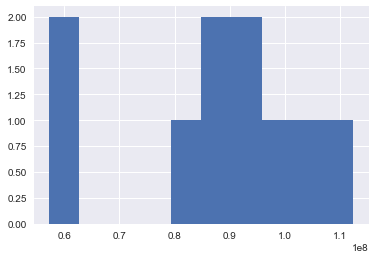

In [70]:
plt.hist(printtemp['goal'])

In [72]:
goals1 = geography_df[['local_name','backers_count']].groupby('local_name').sum()
goals1.reset_index(level=0,inplace=True)

In [82]:
printtemp1 = goals1.sort_values('backers_count',ascending = False)
printtemp1.head(10)

,local_name,backers_count
2256,Los Angeles,677738
2766,New York,414322
3532,San Francisco,377961
3629,Seattle,281930
177,Austin,212517
712,Chicago,184474
484,Brooklyn,179801
422,Boston,152028
3248,Portland,136803
3528,San Diego,121723


In [80]:
printtemp

,local_name,goal
2120,Las Vegas,1.123810e+08
1836,Indianapolis,1.055549e+08
109,Antarctica,1.001929e+08
163,Atlanta,9.234024e+07
2766,New York,9.186977e+07
2256,Los Angeles,9.024562e+07
3528,San Diego,8.661894e+07
4473,Winnemucca,8.000000e+07
1756,Hollywood,5.870330e+07
3131,Philadelphia,5.721191e+07


In [ ]:
plt.hist(printtemp)
plt.hist(printtemp1)

In [86]:
printtemp.set_index('local_name',inplace=True)
printtemp1.set_index('local_name',inplace=True)


In [ ]:
printtemp.corr(printtemp1)

## Geographical Distribution

In [ ]:
import pandas as pd
import json 


In [ ]:
sample_df = pd.read_csv("df_testing.csv")
sample_df.head(10)

In [ ]:
len(sample_df.columns)

#sample_df.drop(columns=(['Unnamed: 0']),inplace=True)


In [ ]:
sample_df['category'].head(5)

In [ ]:
def extract_category_columns(json_obj):
    temp = json.loads(json_obj)
    #print(temp)
    return (temp['name'])

sample_df['product_type']=sample_df['category'].apply(extract_category_columns)

In [ ]:
def extract_location(json_obj):
    try:
        temp = json.loads(json_obj)
        return temp['localized_name']
    except:
        return None
    
sample_df['local_name']=sample_df['location'].apply(extract_location)

In [ ]:
sample_df.head(1000)

In [ ]:
sample_df.drop(columns=(['Unnamed: 0','Unnamed: 0.1','blurb','category','created_at','creator','static_usd_rate','download_date','funding_start','funding_end']),inplace=True)

In [ ]:
sample_df.head(100)

<h2>Subsetting to Plot on a Map of US only</h2>

<h2><font color = 'red'>Doesn't work</h2>

In [ ]:
temp = sample_df.head(100)

In [ ]:
def lat_long(x):
    from geopy.geocoders import Nominatim
    import time
    geolocator = Nominatim()
    try:
        loc = geolocator.geocode(x)
        time.sleep(5) #since the service times out with multiple recurring calls
        return loc[-1]
    except:
        return None
    
temp['coordinates']=temp['local_name'].apply(lat_long)

In [ ]:
plot_data = temp[['local_name','coordinates']]
pdata = plot_data.dropna(axis=0,how='any')

In [ ]:
def createGeoJson(x):
    geo_data = dict()
    geo_data['type'] = 'FeatureCollection'
    geo_data_list = list()
    
    for i in range(len(x)):
        #print(i)
        c_ord = list()
        c_ord.append(x.iloc[i][1])
        data_point = {'geometry':{'coordinates':c_ord,'type':'Point'},
                     'properties':{'zone_id':x.iloc[i][0]}, 'type':'Feature'
                     }
        geo_data_list.append(data_point)
        
    geo_data['features'] = geo_data_list
    return geo_data

In [ ]:
zone_data = createGeoJson(pdata)

In [ ]:
zone_data

In [ ]:
x = temp[['backers_count','local_name']].dropna(axis=0,how='any')
x

In [ ]:
y=x.groupby('local_name').sum()

In [ ]:
y.reset_index(level=0,inplace=True)

In [ ]:
#plotting the map

import folium
m=folium.Map(location=[40.7589,-73.9851], zoom_start=12)

m.choropleth(geo_data=zone_data, data=y,key_on='feature.properties.zone_id',fill_color='RdYlGn')
folium.LayerControl().add_to(m)

In [ ]:
y

In [ ]:
zone_data

In [ ]:
y.isnull().values.any()